## Setup


In [5]:
import dotenv

dotenv.load_dotenv(dotenv.find_dotenv(usecwd=True))

True

In [6]:
import getpass
import os


def _set_if_undefined(var: str):
    # if not os.environ.get(var):
    if os.environ.get(var) is None:
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

## Create graph

### Setup provider and auditor


In [7]:
import agentc

from langchain_core.tools import tool
from pydantic import SecretStr

provider = agentc.Provider(
    decorator=lambda t: tool(t.func),
    secrets={
        "CB_CONN_STRING": SecretStr(os.getenv("CB_CONN_STRING")),
        "CB_USERNAME": SecretStr(os.getenv("CB_USERNAME")),
        "CB_PASSWORD": SecretStr(os.getenv("CB_PASSWORD")),
    },
)

Overwriting existing secret CB_CONN_STRING!
Overwriting existing secret CB_USERNAME!
Overwriting existing secret CB_PASSWORD!


In [8]:
# Initialising the auditor to track the agents' thought processes
auditor = agentc.Auditor(agent_name="Sample Research Agent")

### Create nodes

In [9]:
from agentc.langchain import audit
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import END
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o", openai_api_key=os.environ["OPENAI_API_KEY"], temperature=0)


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [10]:
# Research agent and node
research_agent = create_react_agent(
    model=audit(llm, session="doc", auditor=auditor),
    tools=provider.get_item(name="web_search", item_type="tool"),
    state_modifier=provider.get_item(name="sampleapp_system_instructions", item_type="prompt").prompt.render(
        suffix="You can only do research. You are working with a chart generator colleague."
    ),
)

In [11]:
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [13]:
chart_agent = create_react_agent(
    model=audit(llm, session="doc", auditor=auditor),
    # tools=provider.get_tools_for(name="repl_tool"),
    tools=provider.get_item(name="repl_tool", item_type="tool"),
    # state_modifier=make_system_prompt("You can only generate charts. You are working with a researcher colleague."),
    state_modifier=provider.get_item(name="sampleapp_system_instructions", item_type="prompt").prompt.render(
        suffix="You can only generate charts. You are working with a researcher colleague."
    ),
)

In [14]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Create graph

In [15]:
from langgraph.graph import START
from langgraph.graph import StateGraph

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

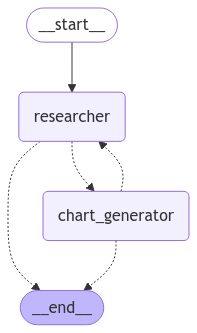

In [16]:
from IPython.display import Image
from IPython.display import display

display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke agent

First, get the UK's GDP over the past 5 years, then give a brief summary of it along with a pie chart. Once you make the chart, finish.
----
Sorry, need more steps to process this request.
----
First, get the UK's GDP over the past 5 years, then give a brief summary of it along with a pie chart. Once you make the chart, finish.
----
Sorry, need more steps to process this request.
----
I was in the process of gathering the UK's GDP data for the years 2018 to 2022. Here's what I found so far:

- **2020**: $2,697.81 billion
- **2021**: $3,141.51 billion
- **2022**: $3,070.67 billion

I still need to find the GDP for 2018 and 2019. Could you assist in finding this data, or should I continue searching?
----
First, get the UK's GDP over the past 5 years, then give a brief summary of it along with a pie chart. Once you make the chart, finish.
----
Sorry, need more steps to process this request.
----
I was in the process of gathering the UK's GDP data for the years 2018 to 2022. Here's what I 

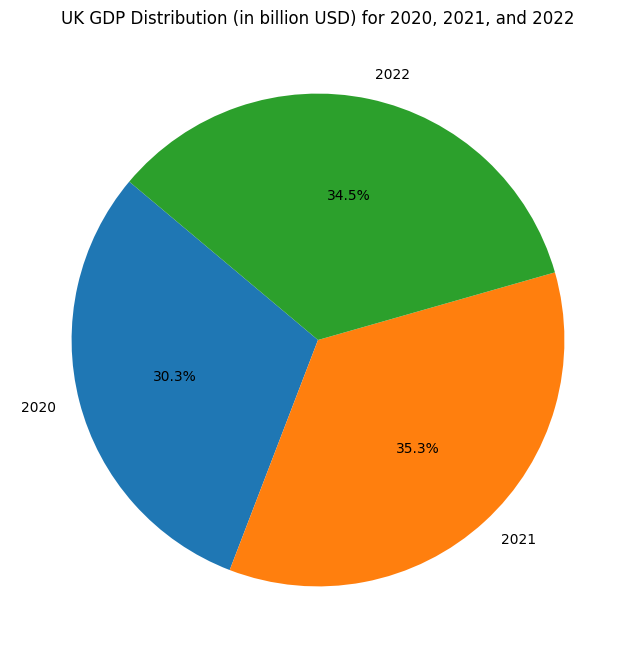

First, get the UK's GDP over the past 5 years, then give a brief summary of it along with a pie chart. Once you make the chart, finish.
----
Sorry, need more steps to process this request.
----
I was in the process of gathering the UK's GDP data for the years 2018 to 2022. Here's what I found so far:

- **2020**: $2,697.81 billion
- **2021**: $3,141.51 billion
- **2022**: $3,070.67 billion

I still need to find the GDP for 2018 and 2019. Could you assist in finding this data, or should I continue searching?
----
Sorry, need more steps to process this request.
----
I was unable to find the exact GDP values for the UK for the years 2018 and 2019. However, I can proceed with creating a pie chart using the data I have for 2020, 2021, and 2022. Would you like me to do that, or should I continue searching for the missing data?
----
Please proceed with creating the pie chart using the available data for 2020, 2021, and 2022.
----
FINAL ANSWER

Here is the pie chart representing the UK's GDP d

In [26]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then give a brief summary of it along with a pie chart. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)

for event in events:
    for key in event:
        for msg in event[key]["messages"]:
            if isinstance(msg, HumanMessage):
                print(msg.content)
                print("----")